# 실습

고객의 이탈 여부를 예측하기 위한 근접이웃 분석을 실시하고 결과를 해석하라.

분석 절차: 
* [데이터 구성하기](#데이터-구성하기)
* [모델 생성](#모델-생성)
* [결론 도출](#결론-도출)



In [1]:
# 데이터 구성 패키지:Series, DataFrame
import pandas as pd

# 행렬 연산 패키지
import numpy as np

# 데이터 시각화 패키지
import matplotlib
import matplotlib.pyplot as plt

# 추세 그래프 및 통계용 차트를 제공하는 시각화 패키지
import seaborn as sns

# train, test 데이터 분할 함수
from sklearn.model_selection import train_test_split

# GridSearchCV : 최적의 파라미터 탐색
from sklearn.model_selection import GridSearchCV

# KNN 패키지
from sklearn.neighbors import KNeighborsClassifier

# confusion matrix
from sklearn.metrics import confusion_matrix

In [2]:
# 한글 폰트(맑은 고딕) 적용
matplotlib.rc("font", family="AppleGothic")

## 데이터 구성하기

In [3]:
# 데이터 불러오기
df_raw = pd.read_csv("~/Documents/Python/DATA/통신고객이탈.CSV", engine = "python")

# drop: X변수외 변수 삭제
df_raw_x = df_raw.drop(["CHURN","CUSTOMER_ID"], axis =1, inplace = False)
df_raw_y = df_raw["CHURN"] 

# get_dummies: 데이터의 문자형 변수에 대한 더미변수 생성 
df_x_dummy = pd.get_dummies(df_raw_x)
df_raw_y = np.where(df_raw_y == "Active", 0, 1)

# train_test_split(X: 설명변수 데이터, Y: 목표변수 데이터, test_size = test 데이터 비율, random_state: 랜덤)
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_x_dummy, # 설명변수 데이터
                                                                df_raw_y, # 목표변수 데이터
                                                                test_size = 0.3, # test 데이터의 비율
                                                                random_state = 1234)  # random state

In [4]:
df_raw.head()

,CHURN,CUSTOMER_ID,GENDER,AGE,CHARGE_TYPE,HANDSET,USAGE_BAND,SERVICE_DURATION,DROPPED_CALLS,PEAK_CALLS_NO,PEAK_CALLS_TIME,WEEKEND_CALLS_NO,WEEKEND_CALLS_TIME,TOTAL_CALLS_NO,TOTAL_CALLS_TIME
0,Active,K102990,F,31,CAT 100,ASAD170,Med,33.33,6,218,379.8,9,21.6,366,632.4
1,Active,K103280,M,27,CAT 100,S50,Med,30.87,10,373,656.4,11,28.0,411,810.4
2,Active,K103660,M,27,CAT 100,ASAD170,Med,49.40,11,260,582.0,0,0.0,265,614.1
3,Active,K103730,M,61,CAT 100,ASAD170,Med,48.60,1,294,661.8,14,101.5,326,844.0
4,Active,K104560,F,52,CAT 100,S50,Med,56.03,0,221,555.6,7,25.0,274,673.0


## 모델 생성

In [5]:
# KNN 모델 생성(default 설정)
knn_uncusotomized = KNeighborsClassifier()
knn_uncusotomized.fit(df_train_x, df_train_y)

# train 데이터 셋 정확도
print("Accuracy on train set: {:.3f}".format(knn_uncusotomized.score(df_train_x, df_train_y)))

# test 데이터 셋 정확도
print("Accuracy on test set: {:.3f}".format(knn_uncusotomized.score(df_test_x, df_test_y)))

Accuracy on train set: 0.820
Accuracy on test set: 0.803


#### 이웃 수 증가에 따른 정확도 변화

In [6]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []

# 최대 이웃 수: 1~15
para_n_neighbors = [i for i in range(1, 16)]

for v_n_neighbors in para_n_neighbors:
    knn = KNeighborsClassifier(n_neighbors = v_n_neighbors)
    knn.fit(df_train_x, df_train_y)
    train_accuracy.append(knn.score(df_train_x, df_train_y))
    test_accuracy.append(knn.score(df_test_x, df_test_y))

# 데이터 테이블로 저장
df_accuracy_neighbors = pd.DataFrame()
df_accuracy_neighbors["Neighbors"] = para_n_neighbors
df_accuracy_neighbors["TrainAccuracy"] = train_accuracy
df_accuracy_neighbors["TestAccuracy"] = test_accuracy
df_accuracy_neighbors.round(3)

,Neighbors,TrainAccuracy,TestAccuracy
0,1,1.000,0.717
1,2,0.851,0.821
2,3,0.843,0.792
3,4,0.825,0.821
4,5,0.820,0.803
5,6,0.822,0.839
6,7,0.819,0.828
7,8,0.806,0.835
8,9,0.810,0.832
9,10,0.805,0.839


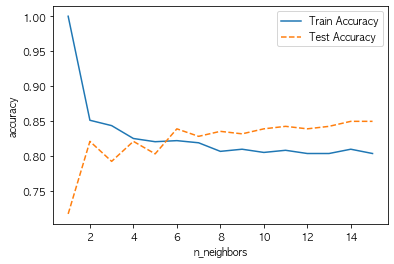

In [7]:
# 정확도를 그래프로 표현
plt.plot(para_n_neighbors, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_n_neighbors, test_accuracy, linestyle = "--", label = "Test Accuracy")
plt.ylabel("accuracy"); plt.xlabel("n_neighbors")
plt.legend()

In [8]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []

# 이웃 수
para_n_neighbors = [i for i in range(1,11)] * 2

# 가중치(uniform, distance)
para_weights = (["uniform"]) * 10 + (["distance"] * 10)

# zip( list1, list2, …)를 사용하면 list1과 list2의 인덱스별 값을 하나씩 가져옴
# 1번 loop: n_neighbors = para_n_neihtbors[0], weights = para_weights[0]
# 2번 loop: n_neighbors = para_n_neihtbors[1], weights = para_weights[1]
for (v_n_neighbors, v_weights) in zip(para_n_neighbors, para_weights):
    knn = KNeighborsClassifier(n_neighbors = v_n_neighbors, weights = v_weights)
    knn.fit(df_train_x, df_train_y)
    train_accuracy.append(knn.score(df_train_x, df_train_y))
    test_accuracy.append(knn.score(df_test_x, df_test_y))    

# 데이터 테이블로 저장
df_accuracy_weights = pd.DataFrame()
df_accuracy_weights["Neighbors"] = para_n_neighbors
df_accuracy_weights["Weights"] = para_weights
df_accuracy_weights["TrainAccuracy"] = train_accuracy
df_accuracy_weights["TestAccuracy"] = test_accuracy
df_accuracy_weights.round(3)

,Neighbors,Weights,TrainAccuracy,TestAccuracy
0,1,uniform,1.000,0.717
1,2,uniform,0.851,0.821
2,3,uniform,0.843,0.792
3,4,uniform,0.825,0.821
4,5,uniform,0.820,0.803
5,6,uniform,0.822,0.839
6,7,uniform,0.819,0.828
7,8,uniform,0.806,0.835
8,9,uniform,0.810,0.832
9,10,uniform,0.805,0.839


In [9]:
# 그림을 그리기 위해 데이터의 형태를 변환
df_accuracy_weights_pivot = df_accuracy_weights.pivot(index = "Neighbors", columns = "Weights",
                                                      values = ["TrainAccuracy", "TestAccuracy"])
df_accuracy_weights_pivot

TrainAccuracy           TestAccuracy          
Weights        distance   uniform     distance   uniform
Neighbors                                               
1                   1.0  1.000000     0.716846  0.716846
2                   1.0  0.850998     0.716846  0.820789
3                   1.0  0.843318     0.788530  0.792115
4                   1.0  0.824885     0.777778  0.820789
5                   1.0  0.820276     0.802867  0.802867
6                   1.0  0.821813     0.802867  0.838710
7                   1.0  0.818740     0.817204  0.827957
8                   1.0  0.806452     0.810036  0.835125
9                   1.0  0.809524     0.820789  0.831541
10                  1.0  0.804916     0.827957  0.838710

In [10]:
# pivot을 이용할 경우, columns와 values이 2개의 level로 이루어지므로 하나의 level로 변환
level0 = df_accuracy_weights_pivot.columns.get_level_values(0)
level1 = df_accuracy_weights_pivot.columns.get_level_values(1)
df_accuracy_weights_pivot.columns = level0 + "_" + level1
df_accuracy_weights_pivot.head()

,TrainAccuracy_distance,TrainAccuracy_uniform,TestAccuracy_distance,TestAccuracy_uniform
Neighbors,,,,
1,1.0,1.000000,0.716846,0.716846
2,1.0,0.850998,0.716846,0.820789
3,1.0,0.843318,0.788530,0.792115
4,1.0,0.824885,0.777778,0.820789
5,1.0,0.820276,0.802867,0.802867


<AxesSubplot:xlabel='Neighbors'>

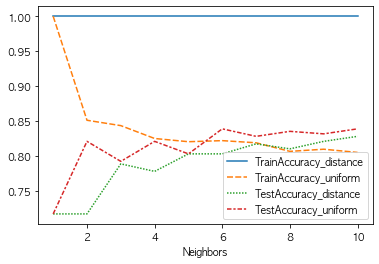

In [11]:
# 그래프 생성. 변수별 linestyle 구분
sns.lineplot(data = df_accuracy_weights_pivot)

In [12]:
# train 및 test 정확도 결과 저장용
train_accuracy = []; test_accuracy = []

# 이웃 수
para_n_neighbors = [i for i in range(1,11)] * 3

# 거리 계산 방법 (minkowski, euclidean, manhattan)
para_metric = ["minkowski"] * 10 + ["euclidean"] * 10 + ["manhattan"] * 10

for (v_n_neighbors, v_metric) in zip(para_n_neighbors, para_metric):
    knn = KNeighborsClassifier(n_neighbors = v_n_neighbors, metric = v_metric, weights = "uniform")
    knn.fit(df_train_x, df_train_y)
    train_accuracy.append(knn.score(df_train_x, df_train_y))
    test_accuracy.append(knn.score(df_test_x, df_test_y))    

# 데이터 테이블로 저장
df_accuracy_metric = pd.DataFrame()
df_accuracy_metric["Neighbors"] = para_n_neighbors
df_accuracy_metric["Metric"] = para_metric
df_accuracy_metric["TrainAccuracy"] = train_accuracy
df_accuracy_metric["TestAccuracy"] = test_accuracy
df_accuracy_metric.round(3)

,Neighbors,Metric,TrainAccuracy,TestAccuracy
0,1,minkowski,1.000,0.717
1,2,minkowski,0.851,0.821
2,3,minkowski,0.843,0.792
3,4,minkowski,0.825,0.821
4,5,minkowski,0.820,0.803
5,6,minkowski,0.822,0.839
6,7,minkowski,0.819,0.828
7,8,minkowski,0.806,0.835
8,9,minkowski,0.810,0.832
9,10,minkowski,0.805,0.839


<AxesSubplot:xlabel='Neighbors'>

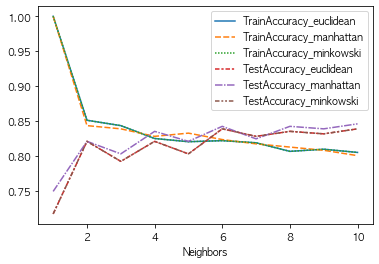

In [13]:
# 정확도를 그래프로 그림
df_accuracy_metric_pivot = df_accuracy_metric.pivot(index = "Neighbors", columns = "Metric",
                                                    values = ["TrainAccuracy", "TestAccuracy"])

level0 = df_accuracy_metric_pivot.columns.get_level_values(0)
level1 = df_accuracy_metric_pivot.columns.get_level_values(1)
df_accuracy_metric_pivot.columns = level0 + "_" + level1
sns.lineplot(data = df_accuracy_metric_pivot)

## 결론 도출

In [14]:
# 최종 모델
knn_model = KNeighborsClassifier(n_neighbors = 4, weights = "uniform", metric = "euclidean")
knn_model.fit(df_train_x, df_train_y)

# 평가
y_pred = knn_model.predict(df_test_x)

# train 데이터 셋 정확도
print("train data accuracy: {0:.3f}".format(knn_model.score(df_train_x, df_train_y)))

# test 데이터 셋 정확도
print("test data accuracy: {0:.3f}\n".format(knn_model.score(df_test_x, df_test_y)))

# confusion matrix
print("Confusion matrix: \n{}".format(confusion_matrix(df_test_y, y_pred)))

train data accuracy: 0.825
test data accuracy: 0.821

Confusion matrix: 
[[227   8]
 [ 42   2]]
